# Naive Bayes Classifier

In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from src.naive_bayes import GNaiveBayes
import src.utils as utils

## Load Data Without Outliers

In [2]:
df = pd.read_csv('data/diamonds.csv')
X_train, X_test, y_train, y_test = utils.preprocessing_LOS(df)

Create a **Gaussian Naive Bayes Classifier** and split our data into training set and validation set.

In [3]:
gnb = GNaiveBayes(random_state=42)
# Cross validation with 20% validation set
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Let's fit the `gnb` model we just created to our training set and see how well it can perform.

In [4]:
gnb.fit(X_train2, y_train2)
score = gnb.score(X_val, y_val)
print("Score on validation set: ", score)
r = gnb.compute_metrics(X_val, y_val)
del r['accuracy']
r

Score on validation set:  0.6048387096774194


{'precision': 0.508588430512589,
 'recall': 0.44299168983161435,
 'f1': 0.45595493637900775}

The score seems to be really low. We have to check which features are important in order to get an understanding on the problem. 

That way we will remove noise and redundancy in our data, potentially increasing the score.

To compute the importances, we'll use **permutation** importance in which the values of every specific feature will be shuffled randomly (permuted), breaking the original relationship that feature had with the target variable (cut).

In [334]:
from prettytable import PrettyTable
import warnings

# Get feature names
features = list(X_train2.columns)

# Calculate permutation importance
importance = gnb.calculate_permutation_importance(X_train2, y_train2, random_state=6)

# Add feature names and importance values to dictionary
def interpret_feature_importance(importance_array, feature_names):
    """
    Interpret feature importance array.

    Parameters:
    importance_array : array-like/list, shape (n_features,)
        Feature importances based on permutation importance.
    feature_names : array-like/list, shape (n_features,)
        Feature names.

    Returns:
    feature_importance : dict, shape (n_features,)
        Feature importances based on permutation importance.
        """
    dict_importance = {}
    for i in range(len(importance_array)):
        dict_importance[feature_names[i]] = importance_array[i]
    return dict_importance

# Get feature importances in a dictionary
results = interpret_feature_importance(importance, features)

# Create a PrettyTable object
table = PrettyTable()

# Define columns
table.field_names = ["Feature", "Importance"]

# Add data to the table
for feature, importance in results.items():
    table.add_row([feature, importance])

# Print the table
print(table)

# To ignore UserWarning
warnings.filterwarnings("ignore", category=UserWarning)


+---------+-----------------------+
| Feature |       Importance      |
+---------+-----------------------+
|  carat  | -0.019807564698075653 |
|  color  | -0.000962176509621715 |
| clarity | 0.0006303915063039511 |
|  depth  |  0.09157266091572669  |
|  table  |   0.1556403450564035  |
|  price  |  -0.01403450564034503 |
|    x    | -0.018447246184472466 |
|    y    |  -0.01725282017252816 |
|    z    |  -0.01615792966157925 |
+---------+-----------------------+


As we can see, the features that have **negative values** suggest that they might have a negative impact on the model's performance. They are less relevant and can even introduce noise in the model. The features with **positive values** indicate that they have a stronger influence on the model's performance and are important in predicting the target variable. 

## Managing importance of features

We'll set an initial threshold of 0.01 to get some features out of the data we train.

In [335]:
# Threshold for importance
threshold = 0.01

# Get features with importance >= threshold
selected_features = [feat for feat, importance in results.items() if importance >= threshold]

# Features to drop
features_to_drop = [feat for feat in results if feat not in selected_features]

# Drop less important features from X_train based on the threshold
X_train_dropped = X_train.drop(features_to_drop, axis=1)

# Split the modified X_train_dropped and y_train into training and validation sets
X_train2, X_val, y_train2, y_val = train_test_split(X_train_dropped, y_train, test_size=0.2, random_state=42)

features = list(X_train2.columns)
print("Features left: ", features)

Features left:  ['depth', 'table']


The only features left on our data are **depth** and **table** which are supposedly the most important for our problem.

Let's see how the model performs now that we dropped all redundant features in the dataset.

In [5]:
gnn = GNaiveBayes(random_state=42)

# Fit the model on the modified training set
gnn.fit(X_train2, y_train2)

score = gnn.score(X_val, y_val)
print("Score on validation set after dropping features: ", score)

Score on validation set after dropping features:  0.6048387096774194


We increased the accuracy up to 0.67 aprox. However, the score seems to keep being low for our specific problem.

Let's compute the rest of the metrics (precision, recall and f1-score).

In [6]:
l = gnn.compute_metrics(X_val, y_val)
del l['accuracy']
l

{'precision': 0.508588430512589,
 'recall': 0.44299168983161435,
 'f1': 0.45595493637900775}

The recall and f1 scores went down quite a bit (although they were already low previously).

Overall, both versions of the model (with and without managing feature importance) have performed below our expectations.

In [8]:
gnn = GNaiveBayes()
gnn.fit(X_train, y_train)
gnn.compute_metrics(X_test, y_test)

{'accuracy': 0.593010752688172,
 'precision': 0.509913701231699,
 'recall': 0.4231474557668853,
 'f1': 0.4349738310889887}

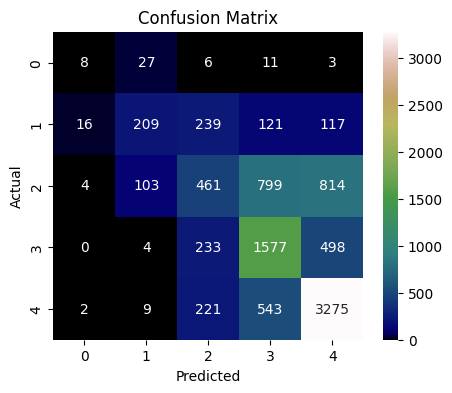

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = gnb.conf_matrix(X_test, y_test)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="gist_earth")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

We won't continue with Naïve Bayes, it's not suitable for our problem.